### Preparatory work

#### Import lib's

In [1]:
import os
import random
from typing import List
from IPython.display import clear_output
from PIL import Image
import logging

import tqdm
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#### Download data from kaggle

In [2]:
# !chmod 600 {os.path.join(os.path.expanduser('~'), '.kaggle', 'kaggle.json')} # for safe download
# !kaggle datasets download -d jeffheaton/traveling-salesman-computer-vision
# !mv traveling-salesman-computer-vision.zip ../data/raw/
# !unzip ../data/raw/traveling-salesman-computer-vision.zip
# !rm -rf ../data/raw/traveling-salesman-computer-vision.zip

#### Set logging config

In [3]:
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

#### Set random seed

In [4]:
SEED = 0
# SEED = 0

def set_seed_everything(seed: int):
    """
    Set random seed everything
    """
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
set_seed_everything(SEED)

In [5]:
font_size = 24

#### Set plot settings

In [6]:
sns.set(rc = {'figure.figsize':(11.7, 8.27)})
sns.set_style(style = 'white')

In [7]:
torch.cuda.is_available()

True

#### Check CUDA

In [8]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(f'Device is {device}')

Device is cuda


#### Set data path

In [9]:
if os.path.exists('../kaggle'):
    DATA_PATH = os.path.abspath('/kaggle/input')
    dirname, _, filenames = os.walk(DATA_PATH)
else:
    DATA_PATH = os.path.abspath('../archive/tsp-cv')
    dirname, filenames = os.walk(os.path.abspath('../archive/'))

#### Define constant

In [10]:
VAL_SIZE = 0.35
TRANSFORMS = transforms.Compose([
    transforms.Resize((528, 528)),
])
NUM_EPOCH = 10

#### Define class fow working with data

In [11]:
class ImageDataset(Dataset):
    """
    Class for working with image dataset
    """
    
    def __init__(
        self, 
        dataset: pd.DataFrame, 
        image_path: str, 
        transform: transforms.Compose = None,
        image_column_name: str = 'image',
        target_column_name: str = 'label',
        train_sample: bool = True
    ):
        self.dataset = dataset
        self.images = image_path
        self.transform = transform
        self.image_column_name = image_column_name
        self.target_column_name = target_column_name
        self.train_sample = train_sample
        
    def __len__(self):
        """
        Method which return the number of objects
        
        Return:
            Lenght of dataset
        """
        
        return len(self.dataset)

    def __getitem__(self, idx: int):
        """
        Return item: object-label
        
        Parametres:
            idx: index of object
        Return:
            Image tensor and his label - fro train and validation samples;
            for test sample return image tensor and index of image
        """
        
        try:
            img_file_name = self.dataset.iloc[idx][self.image_column_name]
        except KeyError: 
            error_msg = f'KeyError: Object by index {idx} not found'
            return error_msg, idx

        image_path = os.path.join(self.images, img_file_name)
        img = Image.open(image_path)

        transformer = transforms.ToTensor()
        img_tensor = transformer(img)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        if self.train_sample:
            label = self.dataset.iloc[idx][self.target_column_name]
            return img_tensor, label
        else:
            index = self.dataset.iloc[idx]['id']
            return img_tensor, index
        
    @staticmethod    
    def get_image(data_path: str) -> str:
        """
        Get image by path excluding tabular data (csv)
        """

        for dirname, _, filenames in os.walk(data_path):
            for filename in filenames:
                if '.csv' in filename:
                    continue
                else:
                    path = os.path.join(dirname, filename)
                    yield path
    
    @staticmethod
    def get_image_tensor(image_path: str) -> torch.Tensor:
        """
        Get image in tesor by file name
        """

        try:
            img = Image.open(image_path)

        except FileNotFoundError:
            error_msg = 'File not found'
            return error_msg

        transformer = transforms.ToTensor()
        img_tensor = transformer(img)
        return img_tensor
    
    @staticmethod 
    def get_parsing_key(key: str):
        """
        Parsing keys of image and return dimensions (height and weight) and city count
        """

        key_list = key.split('-')

        height = int(key_list[0].split('x')[0])
        weight = int(key_list[0].split('x')[1])

        citys = int(key_list[1])

        return height, weight, citys

# Init generator
images = ImageDataset.get_image(DATA_PATH)

#### Define other functions

In [12]:
def plot_history(
    train_history: List, 
    val_history: List, 
    title: str = 'loss'
):
    """
    Plot figure with metrics on train and validation samples
    
    Parametres:
        train_history: list of metrics on train sample
        val_history: list of metrics on validation sample
        title: name of figure
    """
    
    plt.figure()
    plt.title(f'{title}')
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(
        range(
            0, 
            len(train_history) + 1, 
            int(len(train_history) / len(val_history))
        )
    )[1:]
    
    plt.scatter(
        steps, 
        val_history, 
        marker = '+', 
        s = 180, 
        c = 'orange', 
        label = 'val', 
        zorder = 2
    )
    
    plt.xlabel('Epoch')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

#### Test

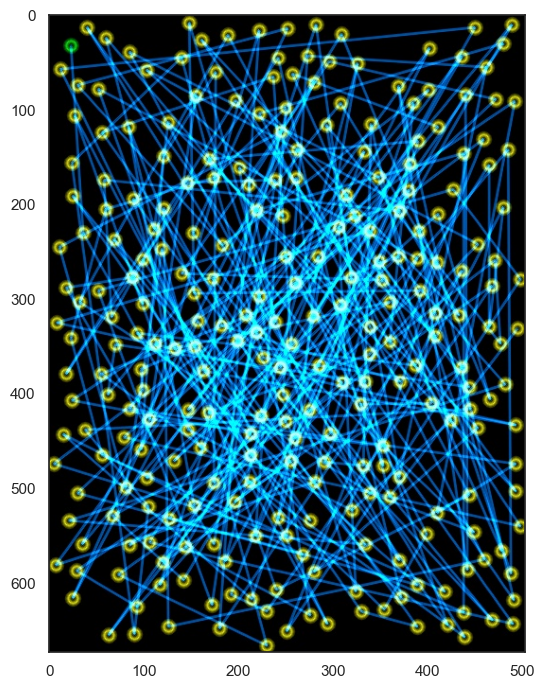

In [13]:
image_path = next(images)
img = Image.open(image_path)
img_tesnor = ImageDataset.get_image_tensor(image_path)
plt.imshow(img)

### Get tabular data files

In [14]:
tabular_data = []

for name in list(filenames[2]):
    if '.csv' in name:
        tabular_data.append(name)
        
tabular_data

['test.csv', 'train.csv', 'tsp-all.csv']

In [15]:
tsp_all = pd.read_csv(os.path.join(filenames[0], tabular_data[2]))
test_data = pd.read_csv(os.path.join(filenames[0], tabular_data[0]))
train_data = pd.read_csv(os.path.join(filenames[0], tabular_data[1]))

In [16]:
tsp_all.head(2)

,id,filename,distance,key
0,0,0.jpg,83110,503x673-270-83110.jpg
1,1,1.jpg,1035,906x222-10-1035.jpg


In [17]:
# Merge "all" dataset to main by id and key
train_data = pd.merge(tsp_all[['id', 'key']], train_data, how = 'inner', on = 'id')
test_data = pd.merge(tsp_all[['id', 'key', 'distance']], test_data, how = 'inner', on = 'id')

In [18]:
train_data.head(2)

,id,key,filename,distance
0,0,503x673-270-83110.jpg,0.jpg,83110
1,1,906x222-10-1035.jpg,1.jpg,1035


In [19]:
test_data.head(2)

,id,key,distance,filename
0,16019,710x395-392-8505.jpg,8505,16019.jpg
1,16020,425x651-195-55783.jpg,55783,16020.jpg


#### Parsing key column

In [20]:
train_keys = pd.DataFrame(
    np.column_stack(
        train_data['key'].apply(
            ImageDataset.get_parsing_key
        ).values
    ).transpose(),
    columns = ['height', 'weight', 'citys']
)
train_data['height'], train_data['weight'], train_data['citys'] = \
train_keys['height'], train_keys['weight'], train_keys['citys']


test_keys = pd.DataFrame(
    np.column_stack(
        test_data['key'].apply(
            ImageDataset.get_parsing_key
        ).values
    ).transpose(),
    columns = ['height', 'weight', 'citys']
)
test_data['height'], test_data['weight'], test_data['citys'] = \
test_keys['height'], test_keys['weight'], test_keys['citys']

In [21]:
train_data, val_data = train_test_split(
    train_data,
    test_size = VAL_SIZE,
    shuffle = True
)
val_data.to_csv('train.csv')
val_data.to_csv('val.csv')

In [22]:
train_data.head(2)

,id,key,filename,distance,height,weight,citys
2888,2888,558x934-136-7542.jpg,2888.jpg,7542,558,934,136
9816,9816,628x674-97-6082.jpg,9816.jpg,6082,628,674,97


In [23]:
val_data.head(2)

,id,key,filename,distance,height,weight,citys
12640,12641,971x292-281-6677.jpg,12641.jpg,6677,971,292,281
7294,7294,923x353-104-6808.jpg,7294.jpg,6808,923,353,104


In [24]:
test_data.head(2)

,id,key,distance,filename,height,weight,citys
0,16019,710x395-392-8505.jpg,8505,16019.jpg,710,395,392
1,16020,425x651-195-55783.jpg,55783,16020.jpg,425,651,195


In [25]:
print(f'Train data: {train_data.shape}')
print(f'Val data: {val_data.shape}')
print(f'Test data: {test_data.shape}')

Train data: (10411, 7)
Val data: (5607, 7)
Test data: (4005, 7)


#### Get sample

In [26]:
image, label = ImageDataset(
    train_data, 
    filenames[0], 
    None, 
    'filename', 
    'distance'
)[0]
assert image != f'KeyError: Object by index {label} not found'

In [27]:
image, label = ImageDataset(
    val_data, 
    filenames[0], 
    None, 
    'filename', 
    'distance'
)[3420]
assert image != f'KeyError: Object by index {label} not found'

In [28]:
image, index = ImageDataset(
    test_data, 
    filenames[0], 
    None, 
    'filename', 
    'distance',
    train_sample = False
)[0]
assert image != f'KeyError: Object by index {index} not found'

### Prepare data for model training

#### Check distribution of image height and weight

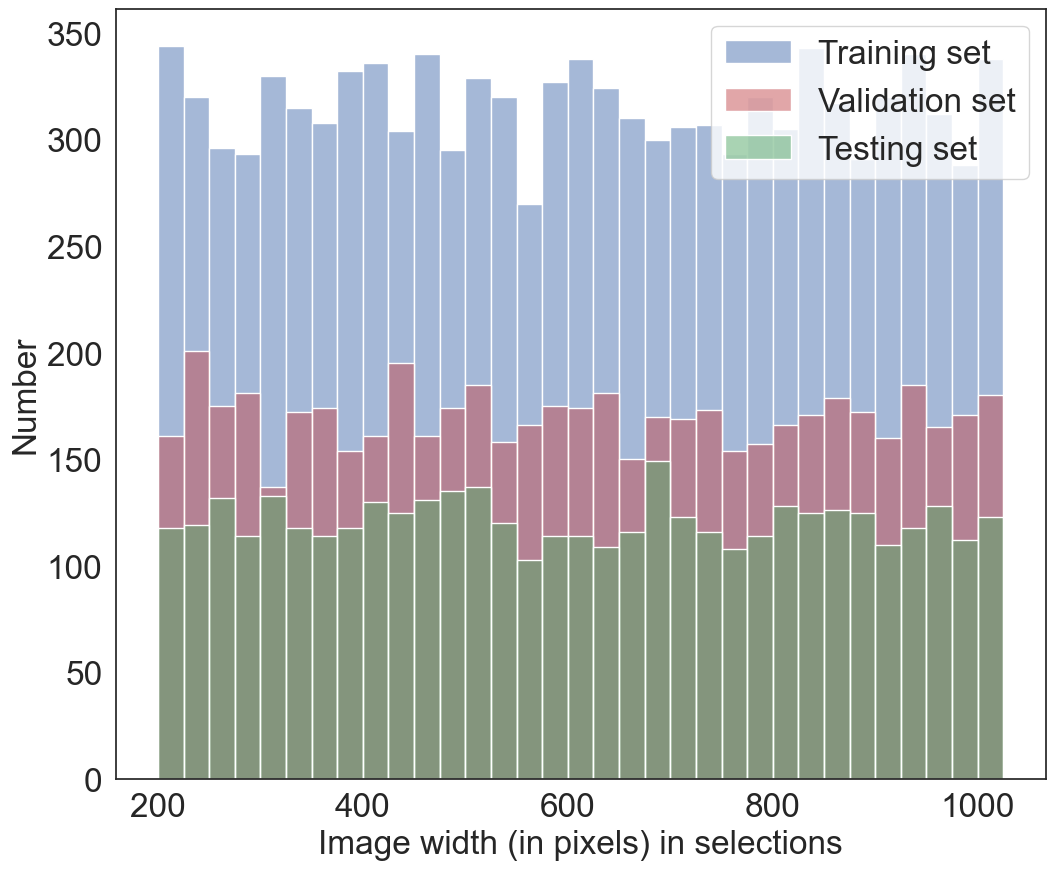

In [29]:

import matplotlib

sns.histplot(train_data['weight'], label = 'Training set', binwidth=25, color='b', alpha = 0.5)
sns.histplot(val_data['weight'], label = 'Validation set', binwidth=25, color='r', alpha = 0.5)
sns.histplot(test_data['weight'], label = 'Testing set', binwidth=25, color='g', alpha = 0.5)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 10)
# plt.title('Width of images (in pixels) in the sets')
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylabel('Number', fontsize=font_size)
plt.xlabel('Image width (in pixels) in selections',fontsize=font_size)
plt.legend(fontsize=font_size,)
plt.savefig("width_dist.pdf")

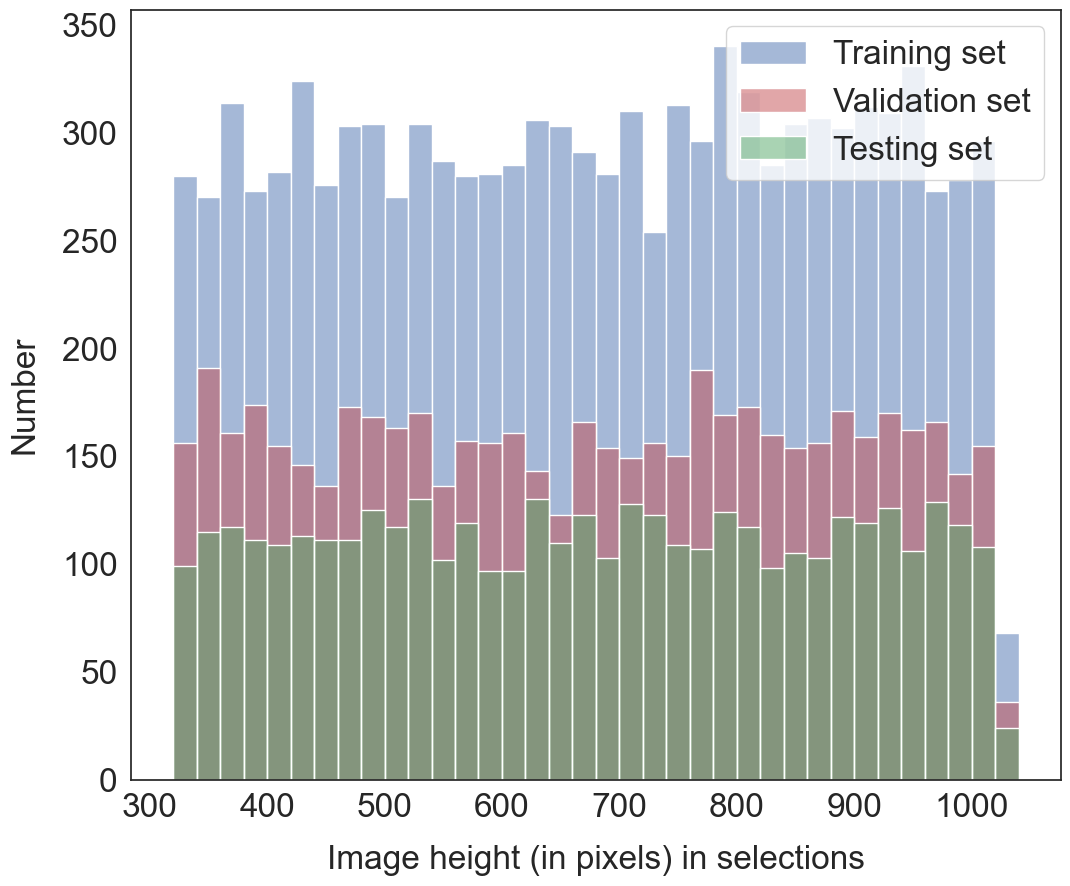

In [30]:
sns.histplot(train_data['height'], label = 'Training set', binwidth=20, color='b', alpha = 0.5, )
sns.histplot(val_data['height'], label = 'Validation set', binwidth=20, color='r', alpha = 0.5, )
sns.histplot(test_data['height'], label = 'Testing set', binwidth=20, color='g', alpha = 0.5, )
# plt.title('Image height (in pixels) in selections', fontsize=14)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 10)
plt.ylabel('Number',fontsize=font_size, labelpad=15)
plt.xlabel('Image height (in pixels) in selections', fontsize=font_size, labelpad=15)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size,loc = 'upper right')
plt.savefig("height_dist.pdf")

#### Small EDA

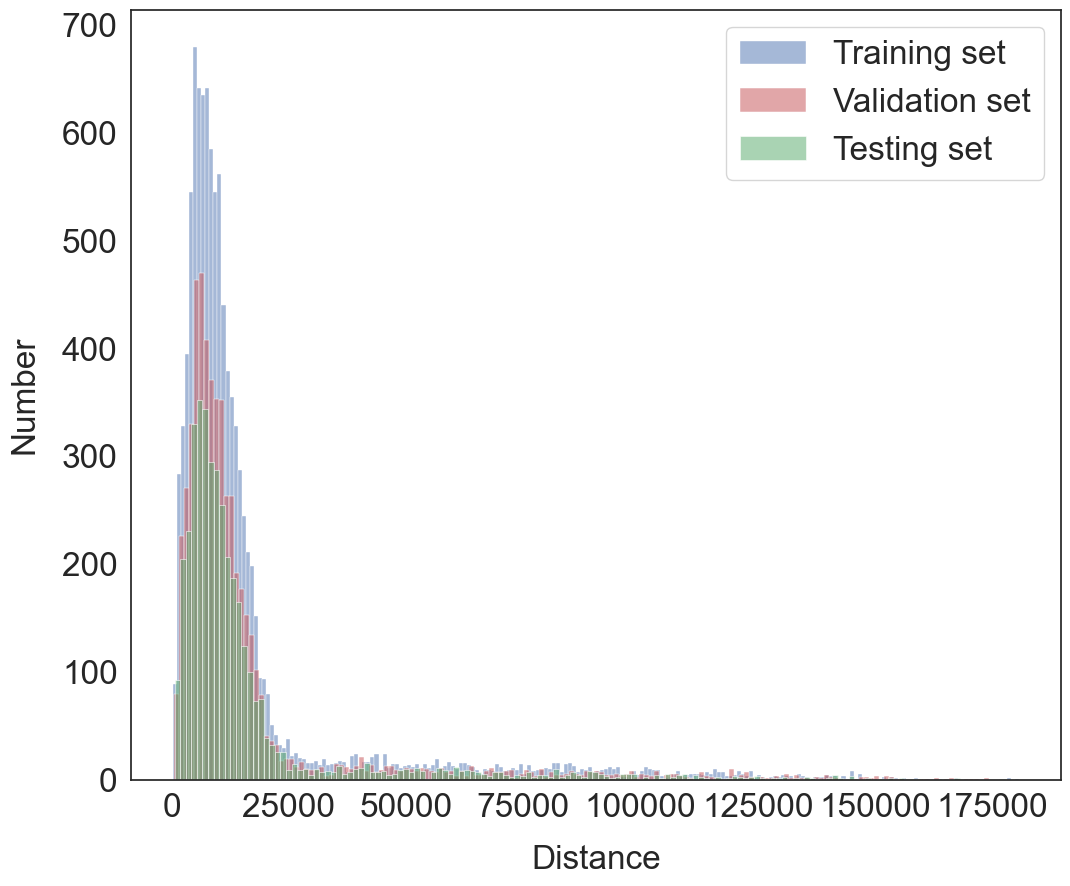

In [31]:
sns.histplot(train_data['distance'], label = 'Training set', color = 'b', alpha = 0.50)
sns.histplot(val_data['distance'], label = 'Validation set', color = 'r', alpha = 0.50)
sns.histplot(test_data['distance'], label = 'Testing set', color = 'g', alpha = 0.50)
# plt.title('Distribution of distances between cities')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 10)
plt.ylabel('Number', fontsize=font_size, labelpad=15)
plt.xlabel('Distance', fontsize=font_size, labelpad=15)
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig("train_val_dist.pdf")

In [32]:
distance_median = train_data['distance'].median()
distance_mean = train_data['distance'].mean()
distance_std = train_data['distance'].std()

print(f'Target median train: {distance_median:.2f}')
print(f'Target mean train: {distance_mean:.2f}')
print(f'Target std train: {distance_std:.2f}')

Target median train: 9512.00
Target mean train: 17684.73
Target std train: 25147.46


In [33]:
distance_median = val_data['distance'].median()
distance_mean = val_data['distance'].mean()
distance_std = val_data['distance'].std()

print(f'Target median val: {distance_median:.2f}')
print(f'Target mean val: {distance_mean:.2f}')
print(f'Target std val: {distance_std:.2f}')

Target median val: 9519.00
Target mean val: 17931.85
Target std val: 26165.06


In [34]:
distance_median = test_data['distance'].median()
distance_mean = test_data['distance'].mean()
distance_std = test_data['distance'].std()

print(f'Target median test: {distance_median:.2f}')
print(f'Target mean test: {distance_mean:.2f}')
print(f'Target std test: {distance_std:.2f}')

Target median test: 9603.00
Target mean test: 17856.62
Target std test: 25381.34


#### Make datasets

In [35]:
train_dataset = ImageDataset(
    train_data, 
    filenames[0], 
    TRANSFORMS, 
    'filename', 
    'distance'
)

val_dataset = ImageDataset(
    val_data, 
    filenames[0], 
    TRANSFORMS, 
    'filename', 
    'distance'
)

test_dataset = ImageDataset(
    test_data, 
    filenames[0], 
    TRANSFORMS, 
    'filename', 
    'distance',
    # train_sample = False
)

#### Make train and test dataloader's

In [36]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size = 32,
    shuffle = True,
    # num_workers = 1,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size = 32,
    shuffle = True,
    # num_workers = 1,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size = 64,
    shuffle = True, 
    # num_workers = 1,
)

### Modeling

#### Define simple Neural Network

In [37]:
class Net(nn.Module):
    """
    Torch model class
    """

    def __init__(self):
        super().__init__()

        self.neural_network = nn.Sequential(
            nn.Conv2d(3, 6, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), 2),
            nn.Conv2d(6, 16, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), 2),
            nn.Flatten(),
            nn.Linear(270400, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, data: torch.Tensor):
        """Make prediction on data
        Args:
            data (tensor): image like tensor
        """
        return self.neural_network(data)


#### Define model

In [38]:
baseline = Net().to(device)
print(baseline)

Net(
  (neural_network): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=270400, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=32, bias=True)
    (12): ReLU()
    (13): Linear(in_features=32, out_features=1, bias=True)
  )
)


#### Define optimizer and criterion

In [39]:
optimizer = torch.optim.Adam(
    baseline.parameters(), 
    lr = 1e-3
)
criterion = nn.MSELoss()

#### Start learn baseline mode with validation

#### Set list's for metrics

In [40]:
train_loss = []
val_loss = []
train_mae = []
val_mae = []
train_mse = []
val_mse = []
train_r2 = []
val_r2 = []

In [41]:
device

'cuda'

Epoch: 10

Loss:
    Train: 54876951.47
    Val: 39824340.39

MAE:
    Train: 3163.38
    Val: 2806.58

MSE:
    Train: 54876951.54
    Val: 39824340.53

R2:
    Train: -703877067765.77
    Val: 0.93


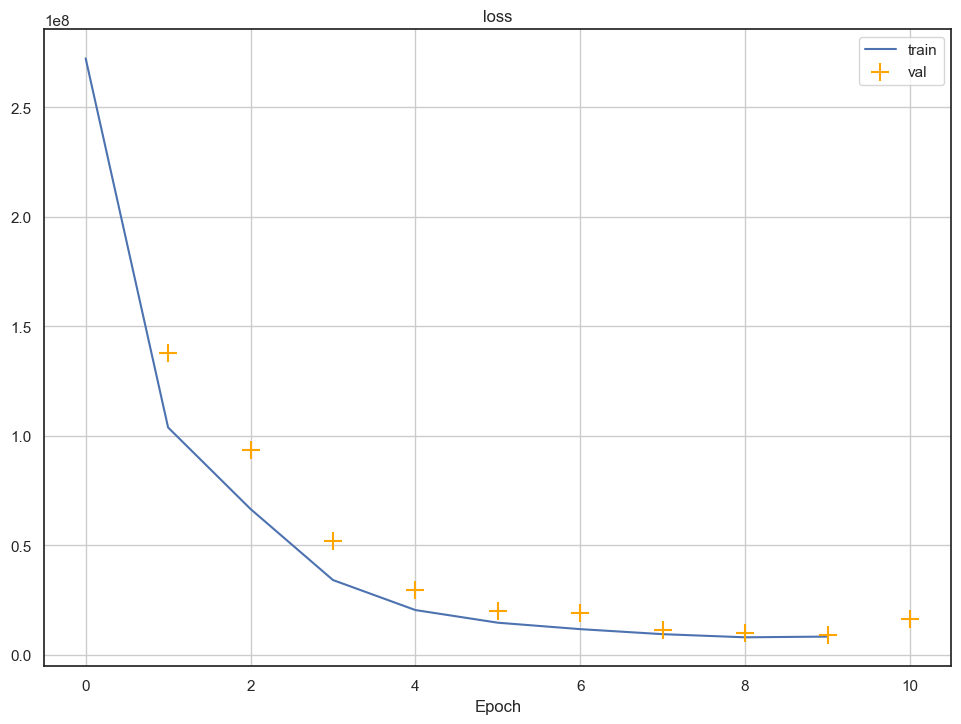

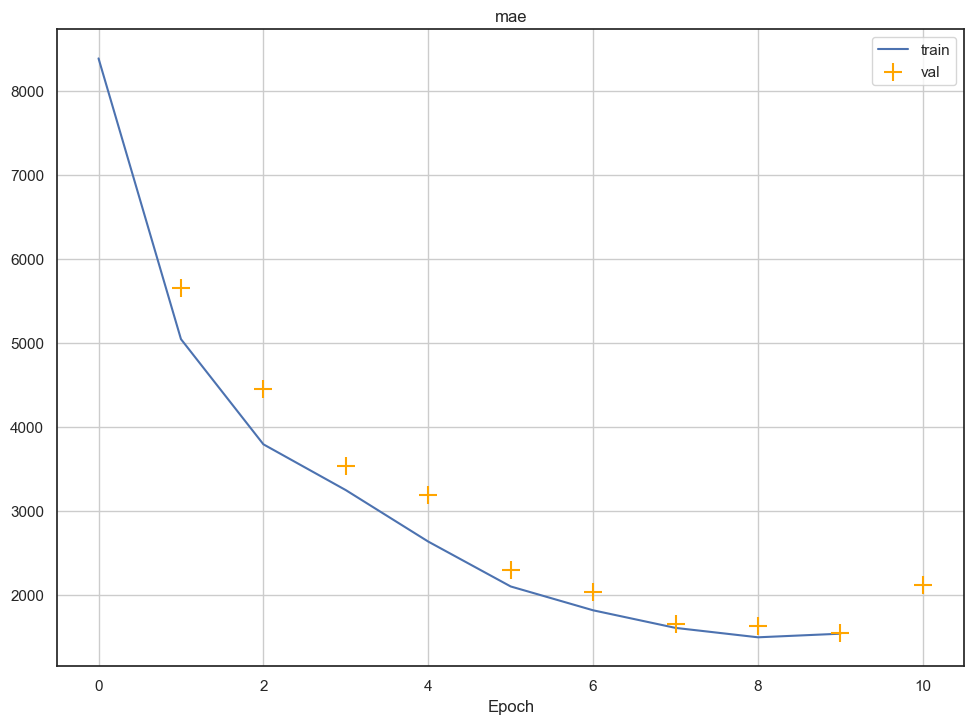

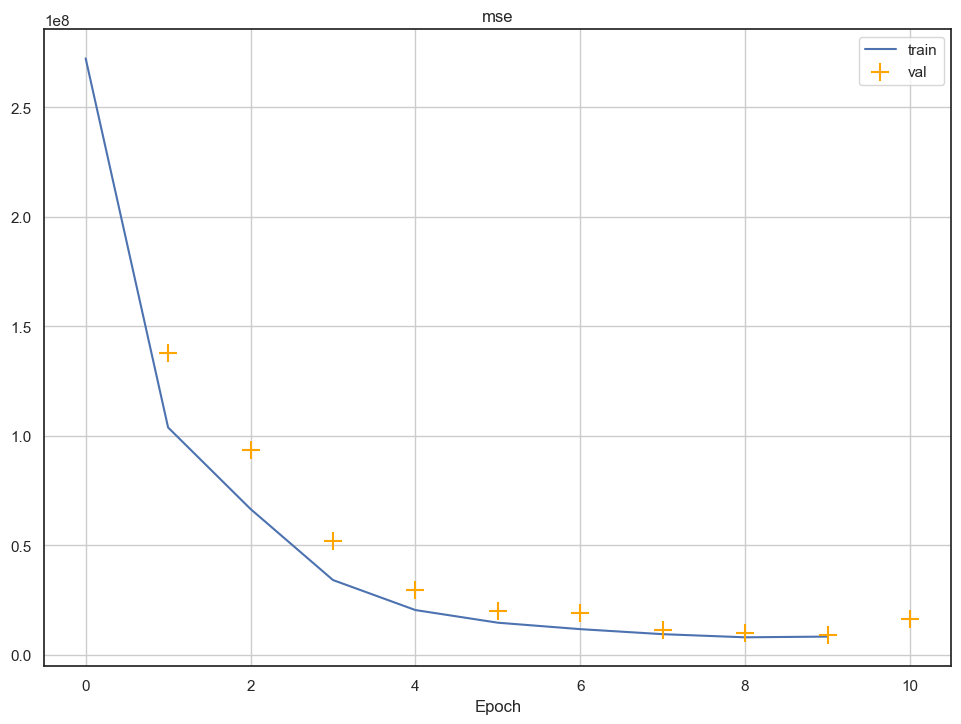

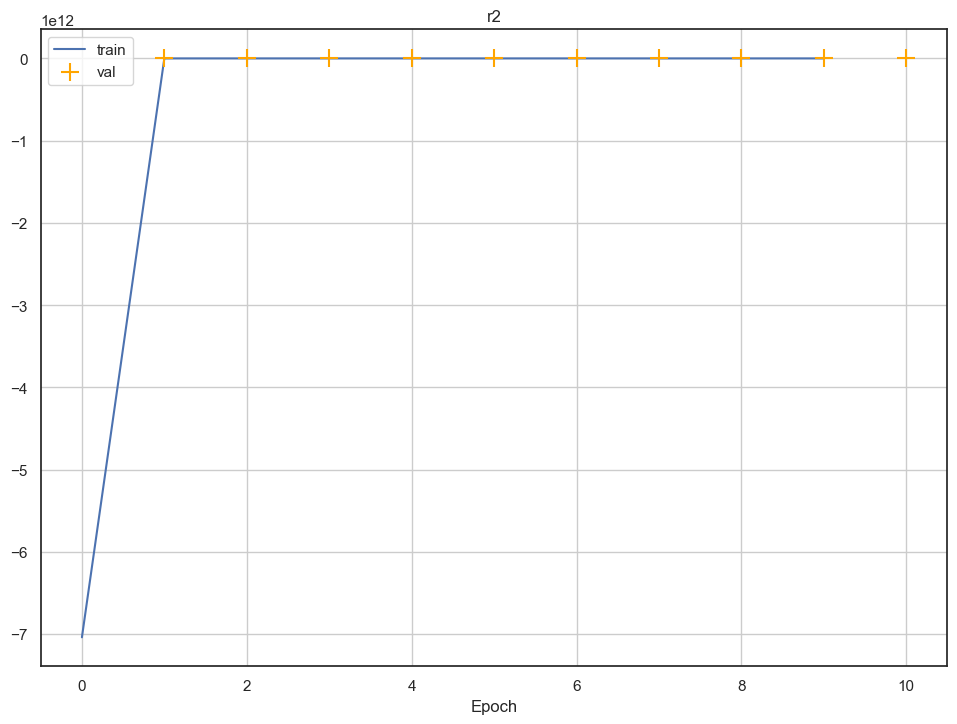

Training is finished


In [42]:
for epoch in range(NUM_EPOCH):    
    loss_train = 0
    mae_train = 0
    mse_train = 0
    r2_train = 0
    
    baseline.train()
    for (i, data) in tqdm.notebook.tqdm(enumerate(train_loader), total = len(train_loader)):
        images, labels = data[0].to(device), data[1].to(torch.float32).to(device)
        
        predictions = baseline.forward(images) # делаем предсказания
        loss = criterion(torch.squeeze(predictions), labels) # считаем лосс
        loss.backward() # считаем градиенты обратным проходом
        optimizer.step() # обновляем параметры сети
        optimizer.zero_grad() # обнуляем посчитанные градиенты параметров
        
        loss_train += float(loss)
        mae_train += mean_absolute_error(predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
        mse_train += mean_squared_error(predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
        r2_train += r2_score(predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
        
    train_loss.append(loss_train / i)
    train_mae.append(mae_train / i)
    train_mse.append(mse_train / i)
    train_r2.append(r2_train / i)
    
    baseline.eval()
    with torch.no_grad():
        loss_val = 0
        mae_val = 0
        mse_val = 0
        r2_val = 0
    
        for i, data in tqdm.tqdm(enumerate(val_loader, 0), total = len(val_loader)):
            images, labels = data[0].to(device), data[1].to(torch.float32).to(device)
            
            predictions = baseline.forward(images)
            
            loss_val_i = criterion(torch.squeeze(predictions), labels)
            
            loss_val += float(loss_val_i)
            mae_val += mean_absolute_error(predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
            mse_val += mean_squared_error(predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
            r2_val += r2_score(predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
        
        val_loss.append(loss_val / i)
        val_mae.append(mae_val / i)
        val_mse.append(mse_val / i)
        val_r2.append(r2_val / i)
            
    clear_output()
            
    print(f'Epoch: {epoch + 1}')
    print(f'\nLoss:\n    Train: {np.mean(train_loss):.2f}\n    Val: {np.mean(val_loss):.2f}')
    print(f'\nMAE:\n    Train: {np.mean(train_mae):.2f}\n    Val: {np.mean(val_mae):.2f}')
    print(f'\nMSE:\n    Train: {np.mean(train_mse):.2f}\n    Val: {np.mean(val_mse):.2f}')
    print(f'\nR2:\n    Train: {np.mean(train_r2):.2f}\n    Val: {np.mean(val_r2):.2f}')
    
    plot_history(train_loss, val_loss, 'loss')
    plot_history(train_mae, val_mae, 'mae')
    plot_history(train_mse, val_mse, 'mse')
    plot_history(train_r2, val_r2, 'r2') 
    
print('Training is finished')

#### Check results

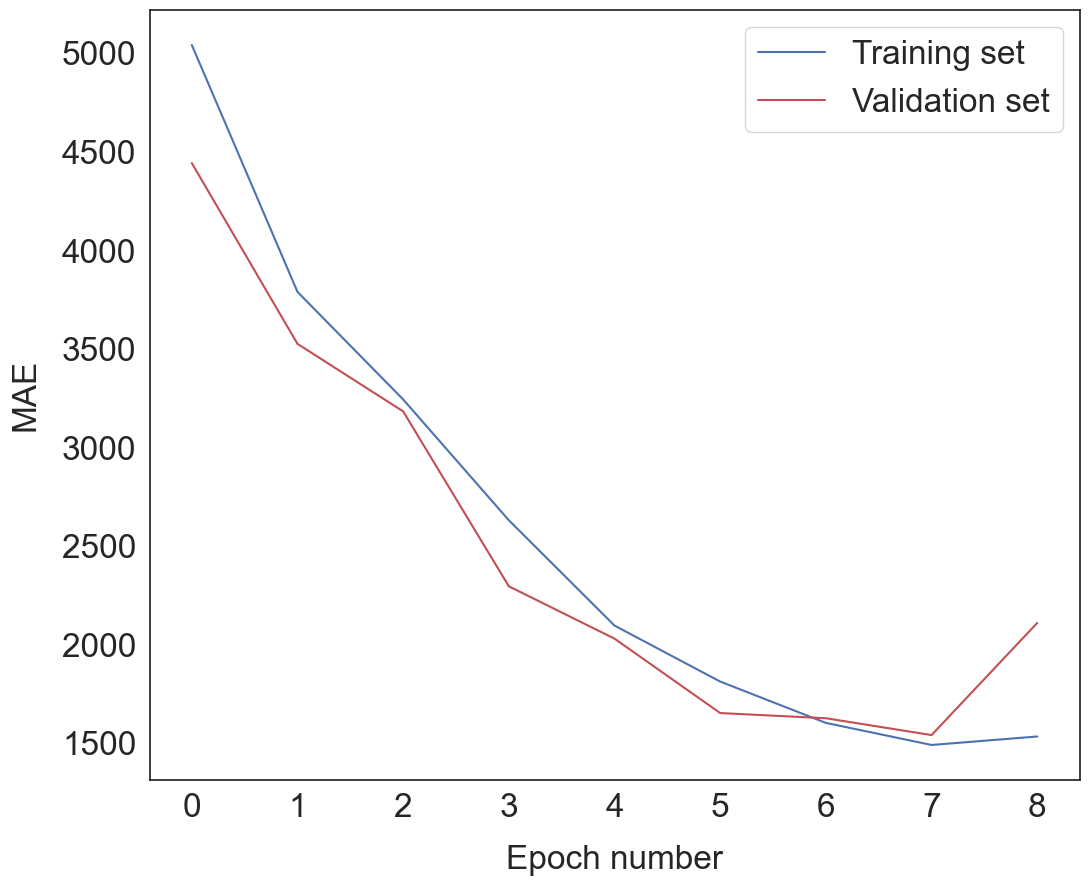

In [43]:
plt.plot(train_mae[1:], label = 'Training set', color = 'b')
plt.plot(val_mae[1:], label = 'Validation set',color = 'r' )
# plt.title('Mean absolute error (MAE)')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 10)
plt.ylabel('MAE',fontsize=font_size, labelpad=15)
plt.xlabel('Epoch number',fontsize=font_size, labelpad=15)
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig("mae_train_val.pdf")

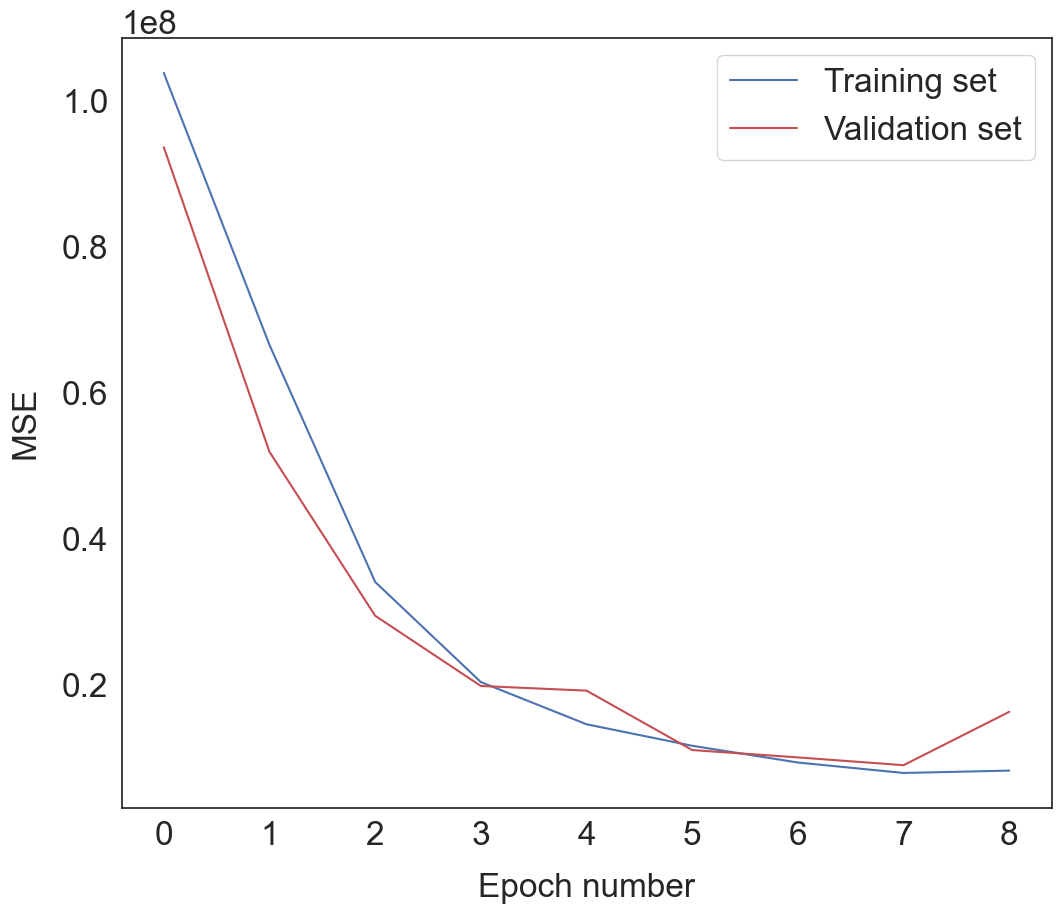

In [44]:
fig, ax = plt.subplots()
plt.plot(train_mse[1:], label = 'Training set',color = 'b')
plt.plot(val_mse[1:], label = 'Validation set',color = 'r')
# plt.title('Mean squared error (MSE)', fontsize=14)

fig.set_size_inches(12, 10)
plt.ylabel('MSE', fontsize=font_size, labelpad=15, )
plt.xlabel('Epoch number', fontsize=font_size, labelpad=15)
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size, )
plt.yticks(fontsize=font_size)
ax.yaxis.offsetText.set_fontsize(font_size)

plt.savefig("mse_train_val.pdf")

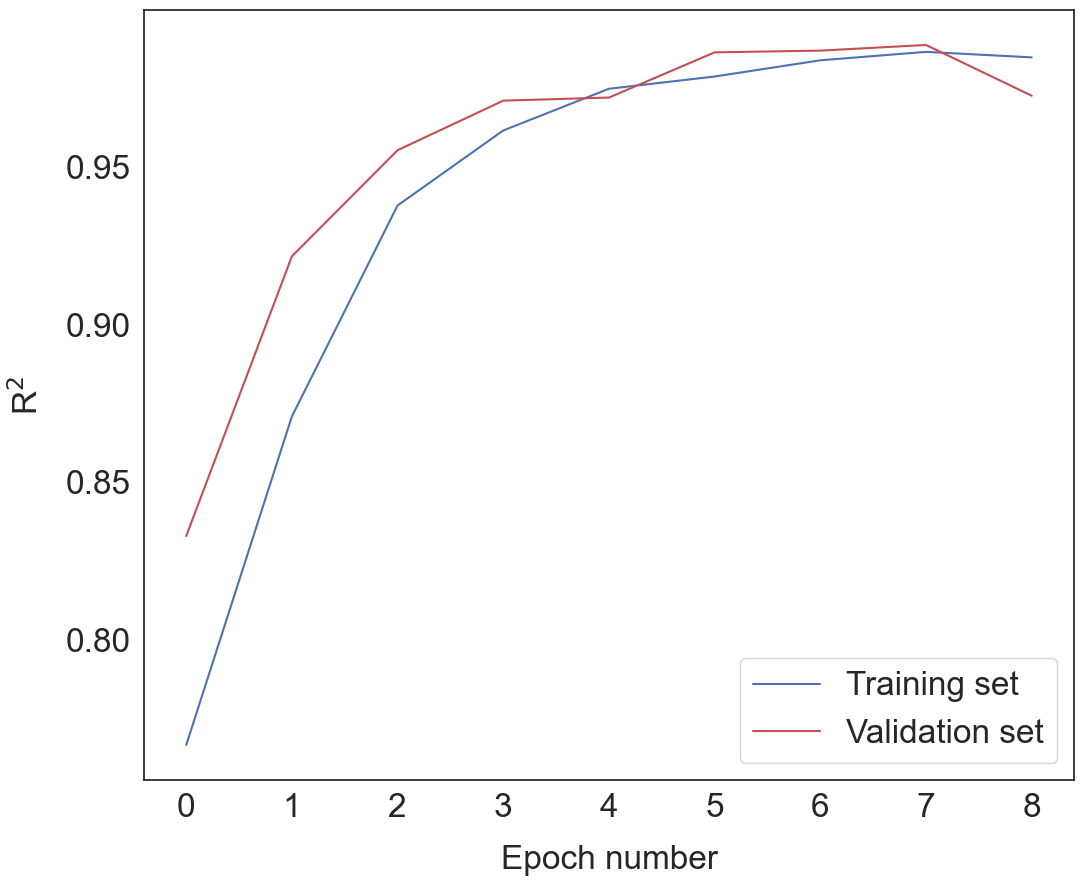

In [45]:
plt.plot(train_r2[1:], label = 'Training set', color = 'b')
plt.plot(val_r2[1:], label = 'Validation set', color = 'r')
# plt.title('R$^2$')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 10)
plt.ylabel('R$^2$', fontsize=font_size, labelpad=15,)
plt.xlabel('Epoch number', fontsize=font_size,labelpad=15,)
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.savefig("r2_train_val.pdf")

### Learn final MVP model

In [46]:
%%time

train_dataset = ImageDataset(
    pd.concat([train_data, val_data]), 
    filenames[0], 
    TRANSFORMS, 
    'filename', 
    'distance'
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size = 32,
    shuffle = True,
    # num_workers = 2,
)

baseline = Net().to(device)

optimizer = torch.optim.Adam(
    baseline.parameters(), 
    lr = 1e-3
)
criterion = nn.MSELoss()

for epoch in range(NUM_EPOCH):
    baseline.train()
    for i, data in tqdm.notebook.tqdm(enumerate(train_loader, 0), total = len(train_loader)):
        images, labels = data[0].to(device), data[1].to(torch.float32).to(device)
        
        predictions = baseline.forward(images)
        loss = criterion(torch.squeeze(predictions), labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
print('Training is finished')

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

Training is finished
CPU times: total: 2h 20min 40s
Wall time: 23min 27s


### Make predictions

In [47]:
def model_inference(
    model: torch.nn.modules.module._IncompatibleKeys,
    dataloader: torch.utils.data.DataLoader,
    device: str = 'cuda',
    test_inference: bool = False
) -> set:
    """
    Make prediction on sample
    
    Parameters:
        model: pytorch NN model
        data_loader: torch dataloader
        device: device for computing results
        
    Return:
        Set with label and predictions on dataloader data
    """
    
    labels_list = np.array([])
    predictions_list = np.array([])
    
    number_iterations = len(dataloader.dataset) // dataloader.batch_size + 1
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        logging.info(f'Model sent to {device}, set to eval mode, gradient calculation disabled')
        logging.info('Start model inference process')
        for i, data in enumerate(dataloader):
            logging.info(f'Start iteration: {i}/{number_iterations}')
            images, label = data[0].to(device), data[1].cpu().detach().numpy()

            predictions = model.forward(images)

            predictions = predictions.squeeze().cpu().detach().numpy()
            
            labels_list = np.append(labels_list, label)
            predictions_list = np.append(predictions_list, predictions)
        
            if test_inference:
                logging.info(f'Test inference is {test_inference}')
                break

    return (labels_list, predictions_list)

#### Val sample

In [48]:
true_label, predicitions = model_inference(baseline, val_loader)

2022-11-28 11:56:24,193 - Model sent to cuda, set to eval mode, gradient calculation disabled
2022-11-28 11:56:24,194 - Start model inference process
2022-11-28 11:56:24,468 - Start iteration: 0/176
2022-11-28 11:56:24,749 - Start iteration: 1/176
2022-11-28 11:56:25,030 - Start iteration: 2/176
2022-11-28 11:56:25,312 - Start iteration: 3/176
2022-11-28 11:56:25,608 - Start iteration: 4/176
2022-11-28 11:56:25,905 - Start iteration: 5/176
2022-11-28 11:56:26,187 - Start iteration: 6/176
2022-11-28 11:56:26,486 - Start iteration: 7/176
2022-11-28 11:56:26,793 - Start iteration: 8/176
2022-11-28 11:56:27,105 - Start iteration: 9/176
2022-11-28 11:56:27,435 - Start iteration: 10/176
2022-11-28 11:56:27,779 - Start iteration: 11/176
2022-11-28 11:56:28,092 - Start iteration: 12/176
2022-11-28 11:56:28,421 - Start iteration: 13/176
2022-11-28 11:56:28,780 - Start iteration: 14/176
2022-11-28 11:56:29,140 - Start iteration: 15/176
2022-11-28 11:56:29,499 - Start iteration: 16/176
2022-11-28

In [49]:
mae_val_all = mean_absolute_error(true_label, predicitions)
mse_val_all = mean_squared_error(true_label, predicitions)
r2_val_all = r2_score(true_label, predicitions)

print(f'MAE on validation set: {mae_val_all:.2f}')
print(f'MSE on validation set: {mse_val_all:.2f}')
print(f'R2 on validation set: {r2_val_all:.2f}')

MAE on validation set: 1200.68
MSE on validation set: 4762818.18
R2 on validation set: 0.99


#### Test sample

In [50]:
true_label, predicitions = model_inference(baseline, test_loader)

2022-11-28 11:57:22,121 - Model sent to cuda, set to eval mode, gradient calculation disabled
2022-11-28 11:57:22,121 - Start model inference process
2022-11-28 11:57:22,935 - Start iteration: 0/63
2022-11-28 11:57:23,935 - Start iteration: 1/63
2022-11-28 11:57:24,826 - Start iteration: 2/63
2022-11-28 11:57:25,706 - Start iteration: 3/63
2022-11-28 11:57:26,581 - Start iteration: 4/63
2022-11-28 11:57:27,573 - Start iteration: 5/63
2022-11-28 11:57:28,555 - Start iteration: 6/63
2022-11-28 11:57:29,728 - Start iteration: 7/63
2022-11-28 11:57:30,588 - Start iteration: 8/63
2022-11-28 11:57:31,464 - Start iteration: 9/63
2022-11-28 11:57:32,418 - Start iteration: 10/63
2022-11-28 11:57:33,372 - Start iteration: 11/63
2022-11-28 11:57:34,372 - Start iteration: 12/63
2022-11-28 11:57:35,279 - Start iteration: 13/63
2022-11-28 11:57:36,249 - Start iteration: 14/63
2022-11-28 11:57:37,219 - Start iteration: 15/63
2022-11-28 11:57:38,188 - Start iteration: 16/63
2022-11-28 11:57:39,153 - S

In [51]:
mae_test_all = mean_absolute_error(true_label, predicitions)
mse_test_all = mean_squared_error(true_label, predicitions)
r2_test_all = r2_score(true_label, predicitions)

print(f'MAE on test set: {mae_test_all:.2f}')
print(f'MSE on test set: {mse_test_all:.2f}')
print(f'R2 on test set: {r2_test_all:.2f}')

MAE on test set: 1575.47
MSE on test set: 10119205.70
R2 on test set: 0.98


In [52]:
test_predictions = pd.DataFrame.from_dict(
    {
        'id': true_label.astype('int'),
        'distance': predicitions.astype('float32')
    }
)

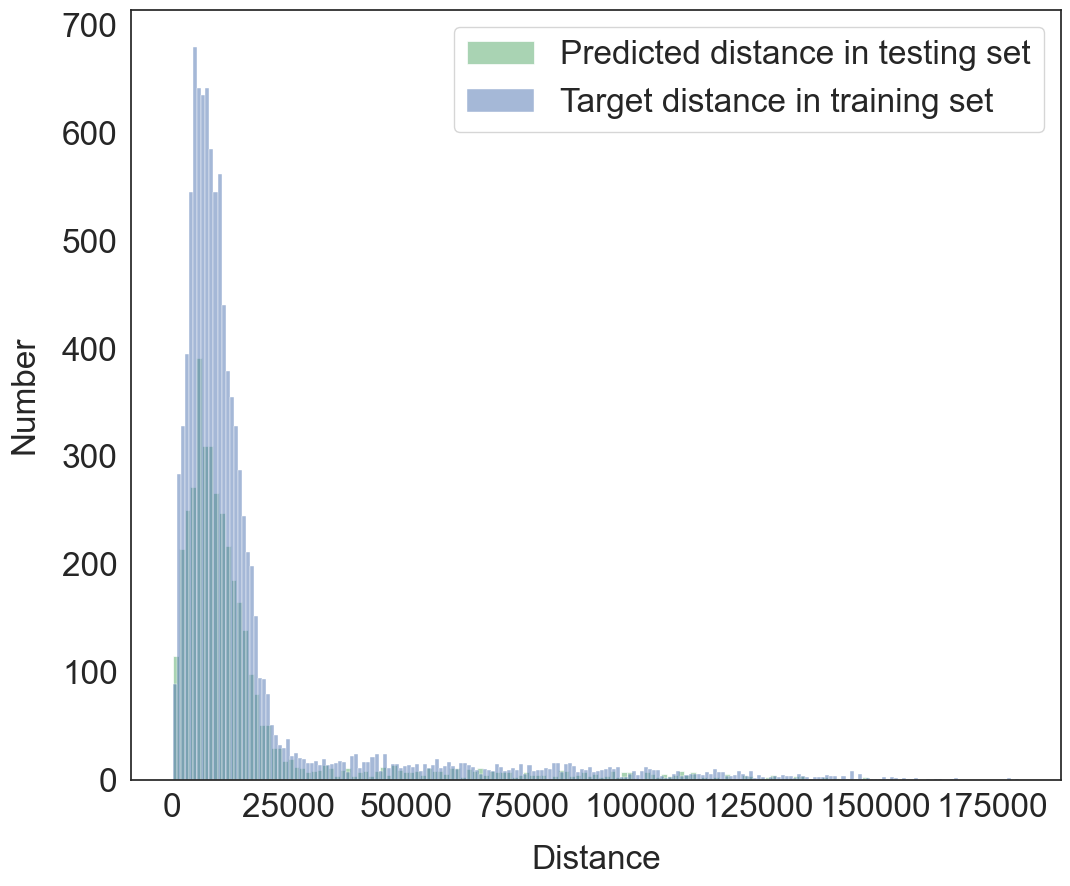

In [53]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 10)
sns.histplot(predicitions, label = 'Predicted distance in testing set', color = 'g', alpha = 0.5)
sns.histplot(train_data['distance'], label = 'Target distance in training set', color = 'b', alpha = 0.5)
# plt.title('Distribution of distances between cities in training set and predicted distances in testing sets')
plt.legend(fontsize=font_size)
plt.ylabel('Number', fontsize=font_size, labelpad=15)
plt.xlabel('Distance', fontsize=font_size, labelpad=15)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig("dist_train_test.pdf")

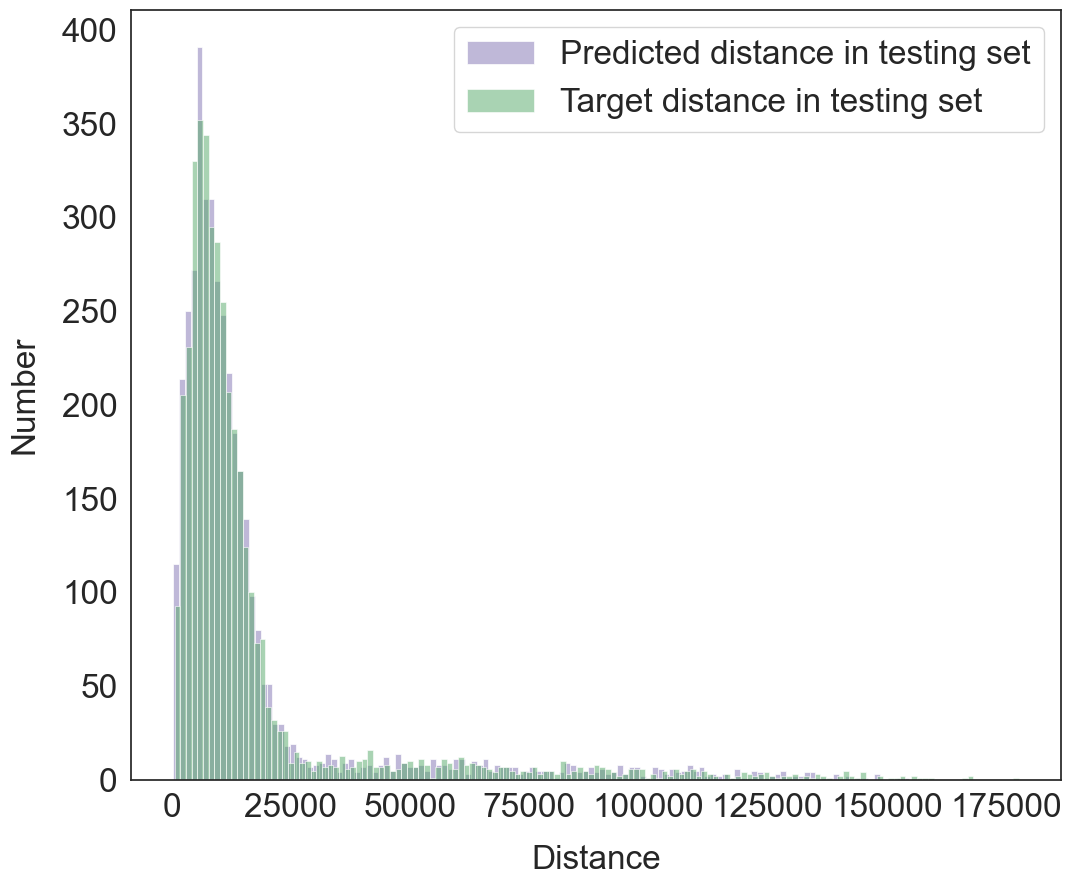

In [54]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 10)
sns.histplot(predicitions, label = 'Predicted distance in testing set', color = 'm', alpha = 0.5)
sns.histplot(test_data['distance'], label = 'Target distance in testing set', color = 'g', alpha = 0.5)
# plt.title('Distribution of distances between cities in training set and predicted distances in testing sets')
plt.legend(fontsize=font_size)
plt.ylabel('Number', fontsize=font_size, labelpad=15)
plt.xlabel('Distance', fontsize=font_size, labelpad=15)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig("dist_test.pdf")

In [55]:
test_predictions.head(2)

,id,distance
0,5980,5719.957031
1,2554,2369.374756


In [56]:
assert test_predictions.shape[0] == test_data.shape[0]

### Save model and test predictions

In [57]:
torch.save(baseline.state_dict(), '../baseline.torch')
test_predictions.to_csv('../test_prediction.csv')

### Load model

In [58]:
baseline_dict = torch.load('../baseline.torch', map_location=torch.device(device))
baseline.load_state_dict(baseline_dict)

<All keys matched successfully>

### TO DO:
- add function for training with validation
- ~~add function for inference~~
- test some transofrms for data
- test some another algorithms (decision trees, stacking, etc.) 